# instructions

# !!!!use fastpitch conda env!!!!

```bash
conda activate fastpitch
cd rlspeller/
./jupyter_lab.sh
```

In [191]:
docstring = """
(Use fastpitch conda env)

Helper script that takes a folder of speech reps (wav2vec2, mel-spec, etc.)
and aligns them at word-level using MFA alignments.

Speech reps corresponding to word tokens in the corpus are then saved individually to an output folder
with the following structure:
- data_path
    - word1
        - word1_LJ010-0292_001.pt
        - word1_LJ010-0292_002.pt
        - ...
    - word2
        - word2_LJ001-0012_001.pt
        - word2_LJ002-0024_001.pt
        - ...
    - ...

- word1, word2, ... subfolders refer to a particular wordtype in the corpus.
- .pt files contain speech representations that map to a particular example of a wordtype.
  It is named as:
    <wordtype>_<utt id>_<numbered occurrence in the utterance>.pt

Example usage:
    #hubert w/ padding offset
    cd ~/fairseq
    python examples/lexicon_learner/wordalign_speechreps.py \
        -t hubert \
        --padding_idx_offset 1 \
        -s /home/s1785140/fairseq/examples/lexicon_learner/lj_speech_quantized.txt \
        -a /home/s1785140/data/ljspeech_MFA_alignments \
        -o /home/s1785140/data/ljspeech_hubert_reps/hubert-base/layer-6/word_level_with_padding_idx_offset

    #hubert w/o padding offset
    cd ~/fairseq
    python examples/lexicon_learner/wordalign_speechreps.py \
        -t hubert \
        --padding_idx_offset 0 \
        -s /home/s1785140/fairseq/examples/lexicon_learner/lj_speech_quantized.txt \
        -a /home/s1785140/data/ljspeech_MFA_alignments \
        -o /home/s1785140/data/ljspeech_hubert_reps/hubert-base/layer-6/word_level_without_padding_idx_offset

    #wav2vec2
    cd ~/fairseq
    python examples/lexicon_learner/wordalign_speechreps.py \
        -t wav2vec2 \
        -s /home/s1785140/data/ljspeech_wav2vec2_reps/wav2vec2-large-960h/layer-15/utt_level \
        -a /home/s1785140/data/ljspeech_MFA_alignments \
        -o /home/s1785140/data/ljspeech_wav2vec2_reps/wav2vec2-large-960h/layer-15/word_level
"""

Command line args

In [201]:
# imitate CLAs
import sys
sys.argv = [
    # fastpitch features
    # 'train.py',
    # '--type', 'mel',
    # '--utt_id_list', '/home/s1785140/data/ljspeech_fastpitch/respeller_uttids.txt', 
    # '--input_directory', '/home/s1785140/data/ljspeech_fastpitch/mels',
    # '--alignments', '/home/s1785140/data/ljspeech_fastpitch/aligns', # older alignments (without using improved tokenizer)
    # '--output_directory', '/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels',

    # speechbrain features
    'train.py',
    '--type', 'wav',
    '--utt_id_list', '/home/s1785140/data/ljspeech_fastpitch/respeller_uttids.txt', 
    '--input_directory', '/home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/data/LJSpeech-1.1/wavs_16khz',
    '--alignments', '/home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/data/LJSpeech-1.1/MFA_alignments_lowercase_nopunc', # newer alignments, lowercase no punctuation
    '--output_directory', '/home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/data/ljspeech_wavs_16khz_word_aligned',
    '--clean-output-folder',
    '--max-utts-to-generate', '100', # for testing!!!
]

# imports and globals

In [203]:
import sys
import os
import argparse
import torch
from tqdm import tqdm
from collections import Counter
import numpy as np
import tgt
import string
import librosa
import glob
import random
from IPython.display import Audio
import nltk
from nltk.corpus import stopwords
import math
import shutil
import matplotlib.pyplot as plt
# nltk.download('stopwords')

SKIP_NON_ASCII = False
WORDS_TO_SKIP = ["wdsu-tv"]

# Parser

In [204]:
parser = argparse.ArgumentParser()
parser.add_argument('-t', '--type', type=str, default='hubert',
                    help='type of input speech reps that we are using, i.e. hubert wav2vec2 etc.')
parser.add_argument('--padding_idx_offset', type=int, default=0,
                    help='add 1 to token id of discrete reps in order to allow for padding_idx==0')
parser.add_argument('--utt_id_list', type=str, required=False, default="",
                    help='path to text file that contains list of utterance ids that we extract from')
parser.add_argument('-s', '--input_directory', type=str, required=True,
                    help='path to single non-nested folder containing speech representations (.pt files) or txt file (hubert)')
parser.add_argument('-a', '--alignments', type=str, required=True,
                    help='path to single non-nested folder containing MFA alignments (.TextGrid files)')
parser.add_argument('-o', '--output_directory', type=str, required=True,
                    help='where to write word-level data')
parser.add_argument('--max-utts-to-generate', type=int, default=None,
                    help='How many utts to extract word aligned speech reps for. If None, extract all utts.')
parser.add_argument('--mel-to-graphemes-ratio-lowest-threshold', type=float, default=0.0,
                    help='Lowest mel-to-graphemes ratio to consider. (lower ratio means fewer mel frames per grapheme)')
parser.add_argument('--mel-to-graphemes-ratio-highest-threshold', type=float, default=math.inf,
                    help='Lowest mel-to-graphemes ratio to consider. (higher ratio means more mel frames per grapheme)')
parser.add_argument('--clean-output-folder', action="store_true",
                    help='Clean output folder before writing new data')
args = parser.parse_args()

if "speechbrain" in args.input_directory:
    args.corpus_name = "speechbrain"
    args.transpose_mel = False
    SAMPLING_RATE = 16000 # hz
    HOP_LENGTH_IN_MS = 10 # in ms
    WIN_LENGTH_IN_MS = 25 # in ms
    HOP_LENGTH = int(HOP_LENGTH_IN_MS * SAMPLING_RATE / 1000) # convert HOP_LENGTH to samples
    WIN_LENGTH = int(WIN_LENGTH_IN_MS * SAMPLING_RATE / 1000) # convert WIN_LENGTH to samples
elif "ljspeech" in args.input_directory:
    args.corpus_name = "ljspeech"
    args.transpose_mel = True
    SAMPLING_RATE = 22050 # hz
    HOP_LENGTH = 256 # in samples

# Functions

# load speech reps

In [205]:
debug = True
if debug:
    # load fewer utts
    max_utts = args.max_utts_to_generate
else:
    max_utts = None

cuda = torch.cuda.is_available()
map_location = 'cuda' if cuda else 'cpu'

if args.type == "hubert":
    with open(args.input_directory, 'r') as f:
        lines = f.readlines()
    num_of_utts = len(lines)
    utt_id2speechreps = {l.split('|')[0]:l.split('|')[1] for l in lines}
    utt_ids = sorted(utt_id2speechreps.keys()) # ensure we always process utts in same alphabetical order
elif args.type == "wav2vec2":
    num_of_utts = len(os.listdir(args.input_directory))
    utt_ids = sorted(file.split('.')[0] for file in os.listdir(args.input_directory))
elif args.type == "mel":
    if args.utt_id_list:
        # we specified a subset of utt ids
        with open(args.utt_id_list, 'r') as f:
            utt_ids = f.read().splitlines()
        print(f"successfully loaded subset of utts from file {args.utt_id_list}")
    else:
        # all files in directory
        utt_ids = list(sorted(file.split('.')[0] for file in os.listdir(args.input_directory)))
    num_of_utts = len(utt_ids)
    utt_ids = utt_ids[:max_utts]
    utt_id2speechreps = {}
    print(f"loading mels from disk in dir {args.input_directory} for {len(utt_ids)} utts")
    for utt_id in tqdm(utt_ids):
        # load mel data
        mel_path = os.path.join(args.input_directory, f'{utt_id}.pt')
        mel = torch.load(mel_path, map_location=map_location)
        if args.transpose_mel:
            mel = mel.transpose(0,1)

        # mels should be of shape (T, D) now
        utt_id2speechreps[utt_id] = mel
elif args.type == "wav":
    # load wav files into utt_id2speechreps
    if args.utt_id_list:
        # we specified a subset of utt ids
        with open(args.utt_id_list, 'r') as f:
            utt_ids = f.read().splitlines()
        print(f"successfully loaded subset of utts from file {args.utt_id_list}")
    else:
        # all files in directory
        utt_ids = list(sorted(file.split('.')[0] for file in os.listdir(args.input_directory)))
    num_of_utts = len(utt_ids)
    utt_ids = utt_ids[:max_utts]
    utt_id2speechreps = {}
    print(f"loading wavs from disk in dir {args.input_directory} for {len(utt_ids)} utts")
    for utt_id in tqdm(utt_ids):
        # load wav data
        wav_path = os.path.join(args.input_directory, f'{utt_id}.wav')
        wav, sr = librosa.load(wav_path, sr=SAMPLING_RATE)
        assert sr == SAMPLING_RATE
        utt_id2speechreps[utt_id] = wav
else:
    raise ValueError(f"invalid input type {args.type}")

# sanity check - assert that each utt has a corresponding alignment
alignment_files = set(os.listdir(args.alignments))
for utt_id in utt_ids:
    assert f"{utt_id}.TextGrid" in alignment_files

print("each utterance has an alignment textgrid file")

successfully loaded subset of utts from file /home/s1785140/data/ljspeech_fastpitch/respeller_uttids.txt
loading wavs from disk in dir /home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/data/LJSpeech-1.1/wavs_16khz for 100 utts


100%|██████████| 100/100 [00:00<00:00, 762.06it/s]

each utterance has an alignment textgrid file


# perform splitting of mel specs using MFA alignments and save to disk

In [206]:
def parse_textgrid(tier, sampling_rate, hop_length, ignore_all_pauses=True):
    # latest MFA replaces silence phones with "" in output TextGrids
    sil_phones = ["sil", "sp", "spn", ""]
    utt_start_time = tier[0].start_time
    utt_end_time = tier[-1].end_time
    phones = []
    durations = [] # NOTE includes durations of silences
    start_frames = []
    end_frames = []
    for i, t in enumerate(tier._objects):
        s, e, p = t.start_time, t.end_time, t.text
        if p not in sil_phones:
            phones.append(p)
            start_frames.append(int(np.ceil(s * sampling_rate / hop_length)))
            end_frames.append(int(np.ceil(e * sampling_rate / hop_length)))
            durations.append(int(np.ceil(e * sampling_rate / hop_length)
                                 - np.ceil(s * sampling_rate / hop_length)))
        else:
            if not ignore_all_pauses:
                if (i == 0) or (i == len(tier) - 1):
                    # leading or trailing silence
                    phones.append("sil")
                else:
                    # short pause between words
                    phones.append("sp")

    n_samples = utt_end_time * sampling_rate
    n_frames = n_samples / hop_length
    # fix occasional length mismatches at the end of utterances when
    # duration in samples is an integer multiple of hop_length
    if n_frames.is_integer():
        durations[-1] += 1
    return phones, durations, start_frames, end_frames, utt_start_time, utt_end_time

def extract_reprs_with_timestamps(total_num_frames, start_time, end_time, utt_duration):
    """
    extract subsequence of 'repr' that corresponds to a particular word
    function expects input to be of dimension 2: (timesteps, hidden_size)
    """
    start_fraction = start_time / utt_duration
    end_fraction = end_time / utt_duration
    # start_idx = math.floor(start_fraction * total_num_frames)
    # end_idx = math.ceil(end_fraction * total_num_frames)
    start_idx = int(start_fraction * total_num_frames)
    end_idx = int(end_fraction * total_num_frames)
    # start_idx = math.floor(start_fraction * total_num_frames)
    # end_idx = math.ceil(end_fraction * total_num_frames)
    num_frames = end_idx - start_idx
    return start_idx, end_idx, num_frames

def parse_textgrid2(tier, speechreps, ignore_all_pauses=True):
    # latest MFA replaces silence phones with "" in output TextGrids
    total_num_frames = speechreps.size(0)
    sil_phones = ["sil", "sp", "spn", ""]
    utt_start_time = tier[0].start_time
    utt_end_time = tier[-1].end_time
    words = []
    word_durations = [] 
    sil_durations = []
    start_frames = []
    end_frames = []
    for i, t in enumerate(tier._objects):
        start, end, token = t.start_time, t.end_time, t.text
        start_idx, end_idx, num_frames = extract_reprs_with_timestamps(total_num_frames, start, end, utt_end_time)
    
        if token not in sil_phones:
            words.append(token)
            start_frames.append(start_idx)
            end_frames.append(end_idx)
            word_durations.append(num_frames)
        else:
            sil_durations.append(num_frames)

    return words, word_durations, sil_durations, start_frames, end_frames, utt_start_time, utt_end_time

In [207]:
# get list of wordnet nltk stopwords
stop_words = set(stopwords.words('english'))
print(f"{len(stop_words)=}")

# add to stop_words all letters in alphabet, since tokenisation might create these edge cases 
# for example, "wasn't" might get tokenized as "wasn" and "t"
stop_words.update(string.ascii_lowercase)
print(f"{len(stop_words)=}")
print(sorted(stop_words))

len(stop_words)=179
len(stop_words)=197
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'b', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'c', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'e', 'each', 'f', 'few', 'for', 'from', 'further', 'g', 'h', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'j', 'just', 'k', 'l', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'n', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'p', 'q', 'r', 're', 's

In [208]:
import soundfile

def allowed_word(word: str) -> bool:
    if len(word) <= 1:
        return False
    return True

def save_to_disk(tensor, word, utt_id, count, length, output_directory, output_format):
    output_directory = os.path.join(output_directory, word)
    os.makedirs(output_directory, exist_ok=True)
    save_path = os.path.join(output_directory, f'{word}__{utt_id}__occ{count}__len{length}')
    if output_format == 'wav':
        save_path += '.wav'
        soundfile.write(save_path, tensor.numpy(), SAMPLING_RATE)
    else:
        save_path += '.pt'
        torch.save(tensor, save_path)

In [209]:
longest_word = ''
longest_word_utt_id = ''
longest_word_num_frames = 0
buffer_frames = 0
num_tokens_skipped_due_to_reps_to_graphemes_ratio = 0
num_stopwords_skipped = 0
skip_stopwords = True
filter_by_len_ratio = False

os.makedirs(args.output_directory, exist_ok=True)

if args.clean_output_folder:
    print(f"cleaning output folder... '{args.output_directory}'")
    shutil.rmtree(args.output_directory, ignore_errors=True)
    print("finished cleaning output folder!")

# glob recursively number of torch tensor files in output directory
orig_num_files = len(glob.glob(os.path.join(args.output_directory, '**', '*.pt'), recursive=True))

# split each speech reps file using the word-level alignments
print("split speech reps using word alignments")
for utt_id in tqdm(utt_ids):
    # load speech reps
    if args.type == "hubert":
        reps = utt_id2speechreps[utt_id]
        reps = [int(s)+args.padding_idx_offset for s in reps.split(' ')] # NOTE add 1 to each index so that 0 is available as a padding_idx
        reps = torch.tensor(reps)
        reps.requires_grad = False

        # check dimensions
        if reps.dim() == 1:
            pass
        else:
            raise ValueError("speech representations have an incorrect number of dimensions")
    elif args.type == "mel":
        reps = utt_id2speechreps[utt_id]
        reps.requires_grad = False

        # check dimensions
        if reps.dim() == 2:
            if args.corpus_name == 'speechbrain' and reps.size(1) == 40:
                pass
            elif args.corpus_name == 'ljspeech' and reps.size(1) == 80:
                pass
            else:
                raise ValueError(f"feat dimension is wrong size for corpus {reps.size(1)=}")    
        else:
            raise ValueError(f"speech representations have an incorrect number of dimensions {reps.dim()=}")
    elif args.type == "wav":
        reps = utt_id2speechreps[utt_id]
        reps = torch.tensor(reps)
        reps.requires_grad = False

        # check dimensions
        if reps.dim() == 1:
            pass
        else:
            raise ValueError(f"wav tensor have an incorrect number of dimensions {reps.dim()=}")
    else:
        raise ValueError(f"invalid input type {args.type}")

    tg_path = f"{args.alignments}/{utt_id}.TextGrid"
    tg = tgt.io.read_textgrid(tg_path, include_empty_intervals=True)

    words, word_durs, sil_durations, start_frames, end_frames, utt_start, utt_end = parse_textgrid2(
        tg.get_tier_by_name('words'), reps, ignore_all_pauses=True
    )
    
    word_occ_in_utt_counter = Counter()

    # verify that MFA frame durations match up with the extracted repss
    assert reps.size(0) == (sum(word_durs) + sum(sil_durations)), f"{reps.size(0)=} != {sum(word_durs)=} + {sum(sil_durations)=}" 

    # iterate over words in utterance
    for j, (word, dur, start_frame, end_frame) in enumerate(zip(words, word_durs, start_frames, end_frames)):
        if skip_stopwords and word in stop_words:
            num_stopwords_skipped += 1
            continue

        if not allowed_word(word):
            continue
                
        if normalise_non_ascii: # normalise word
            prenorm_word = word
            # remove trailing '-'
            word = word.rstrip('-')
            # convert diacritics to ascii
            word = unidecode.unidecode(word)
            print(f"\tnormalised '{prenorm_word}' to '{word}'")
        
        # check if word is the longest word we have seen so far
        word_dur = end_frame - start_frame 
        if word_dur > longest_word_num_frames:
            longest_word_num_frames = word_dur
            longest_word = word
            longest_word_utt_id = utt_id

        # extract reps
        a = max(0, start_frame - buffer_frames)
        b = min(reps.size(0), end_frame + buffer_frames)
        wordaligned_reps = reps[a:b]

        # save extracted reps to disk
        word_occ_in_utt_counter[word] += 1
        extracted_timesteps = wordaligned_reps.size(0)

        assert dur == extracted_timesteps - (start_frame - a) - (b - end_frame) == word_dur, f"{dur=}, {extracted_timesteps=}, {word_dur=}"
        save_to_disk(wordaligned_reps, word, utt_id, word_occ_in_utt_counter[word], extracted_timesteps, args.output_directory, output_format='wav')

print(f"wordtype with longest num of timesteps is '{longest_word}' from", longest_word_utt_id, "with len", longest_word_num_frames)
print("you can set transformer max_source_positions to this")

new_num_files = len(glob.glob(os.path.join(args.output_directory, '**', '*.pt'), recursive=True))

print(f"Added {new_num_files - orig_num_files} files to {args.output_directory}, \nnow contains {new_num_files} files, used to contain {orig_num_files} files")

cleaning output folder... '/home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/data/ljspeech_wavs_16khz_word_aligned'
finished cleaning output folder!
split speech reps using word alignments


100%|██████████| 100/100 [00:32<00:00,  3.09it/s]


wordtype with longest num of timesteps is 'uncompromising' from LJ001-0068 with len 19840
you can set transformer max_source_positions to this
Added 0 files to /home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/data/ljspeech_wavs_16khz_word_aligned, 
now contains 0 files, used to contain 0 files


## sanity check alignments by generating wordaligned spectrograms using griffin-lim

In [210]:
# grab all wavs and words in the output directory
wav_paths = glob.glob(os.path.join(args.output_directory, '**', '*.wav'), recursive=True)
words = [wav_path.split('/')[-2] for wav_path in wav_paths]

## listen to generated audio for each word

In [211]:
# play wav file in notebook and print word
def play_wav(wav_path):
    display(Audio(wav_path))

In [212]:
# words_to_synth = "stopwords"
words_to_synth = "functionwords"
tuples = list(zip(wav_paths, words))
# filter out words that are not in the wordnet nltk stopwords list
if words_to_synth == "stopwords":
    tuples = [t for t in tuples if t[1] in stop_words]
# filter out words that are not in the function word list
elif words_to_synth == "functionwords":
    tuples = [t for t in tuples if t[1] not in stop_words]

In [213]:
def play_wavs_with_silences(wav_paths, silence_duration=0.4):
    # concatenate wavs together into a single wav with silences in between
    wavs = [librosa.load(wav_path, sr=SAMPLING_RATE)[0] for wav_path in wav_paths]
    print(f"1 {wavs[0]}")
    print(f"2 {type(wavs[0])}")
    concatenated_wav = wavs[0]
    silence = np.zeros(int(silence_duration * SAMPLING_RATE), dtype=np.float32)
    for wav in wavs[1:]:
        concatenated_wav = np.concatenate((concatenated_wav, silence, wav))
        # np.cat(concatenated_wav, np.zeros(int(silence_duration * SAMPLING_RATE))
        # concatenated_wav += wav
    # play concatenated wav

    print(concatenated_wav)
    print("concatenated wav shape:", concatenated_wav.shape)
    display(Audio(concatenated_wav, rate=SAMPLING_RATE))

NUM_TO_LISTEN = 25
generate_all = True
if generate_all:
    # Generate all words in tuples
    wav_paths_to_gen = [t[0] for t in tuples[:NUM_TO_LISTEN]]
    words_to_gen = [t[1] for t in tuples[:NUM_TO_LISTEN]]

    # sort mels and words by alphabetical order of words
    wav_paths_to_gen, words_to_gen = zip(*sorted(zip(wav_paths_to_gen, words_to_gen), key=lambda x: x[1]))

    print("Generating audio for following words:", words_to_gen)

    play_wavs_with_silences(wav_paths_to_gen, silence_duration=0.4)

Generating audio for following words: ('arts', 'comparatively', 'concerned', 'crafts', 'differs', 'exhibition', 'modern', 'modern', 'modern', 'present', 'printing', 'printing', 'printing', 'printing', 'printing', 'printing', 'printing', 'printing', 'printing', 'printing', 'printing', 'printing', 'represented', 'represented', 'sense')
1 [ 0.09463501  0.12081909  0.13409424 ... -0.01095581  0.00515747
  0.01437378]
2 <class 'numpy.ndarray'>
[ 0.09463501  0.12081909  0.13409424 ... -0.00057983 -0.00039673
  0.        ]
concatenated wav shape: (366079,)


# Filter poor alignments

In [270]:
""" filter out alignments based on certain criteria 
- where ratio of wav samples to graphemes is too low
- graphemes is too short

why? because fastpitch will not synthesise these words with very fast or very slow pace. 

some problematic ones:
    - surpassed

from the below code, seems that mel-to-graphemes ratio of 
    - > 15.0 includes many examples of poor alignments
    - < 
"""

' filter out alignments based on certain criteria \n- where ratio of wav samples to graphemes is too low\n- graphemes is too short\n\nsome problematic ones:\n    - surpassed\n\nfrom the below code, seems that mel-to-graphemes ratio of \n    - > 15.0 includes many examples of poor alignments\n    - < \n'

In [271]:
# create dict where key is filename and value is another dict with wav array, wav length and wordtype
wav_dict = {}
for wav_path in wav_paths:
    word = wav_path.split('/')[-2]
    basename = os.path.basename(wav_path).rstrip('.wav')
    wav = librosa.load(wav_path, sr=SAMPLING_RATE)[0]
    wav_dict[basename] = {
        "wav": wav,
        "wav_len": len(wav),
        "wordtype": word,
        "samples_to_graphemes_ratio": len(wav) / len(word),
    }

In [277]:
# identify outliers in wav_dict according to samples_to_graphemes_ratio
samples_to_graphemes_ratios = [wav_dict[key]["samples_to_graphemes_ratio"] for key in wav_dict]
samples_to_graphemes_ratios = np.array(samples_to_graphemes_ratios)
mean = np.mean(samples_to_graphemes_ratios)
std = np.std(samples_to_graphemes_ratios)
print(f"mean: {mean}, std: {std}")

outliers = []
NUM_STDS = 1.5
for key in wav_dict:
    if wav_dict[key]["samples_to_graphemes_ratio"] > mean + NUM_STDS * std or wav_dict[key]["samples_to_graphemes_ratio"] < mean - NUM_STDS * std:
        outliers.append(key)
print(f"Found {len(outliers)} outliers (using threshold of {NUM_STDS} stds), out of a total of {len(wav_dict)} files, which is {len(outliers) / len(wav_dict) * 100:.2f}%")

# create list of tuples of (word, wav_len) for all outliers
outlier_tuples = []
for key in outliers:
    wav_len = wav_dict[key]["wav_len"]
    wordtype = wav_dict[key]["wordtype"]
    samples_to_graphemes_ratio = wav_dict[key]["samples_to_graphemes_ratio"]
    outlier_tuples.append((wordtype, wav_len, samples_to_graphemes_ratio))
outlier_tuples = sorted(outlier_tuples, key=lambda x: x[2], reverse=True)

if False:
    for outlier_tuple in outlier_tuples:
        print(outlier_tuple)

mean: 1324.8997929212574, std: 406.6283688002027
Found 79 outliers (using threshold of 1.5 stds), out of a total of 891 files, which is 8.87% of the total files.


mean: 1324.90, std: 406.63


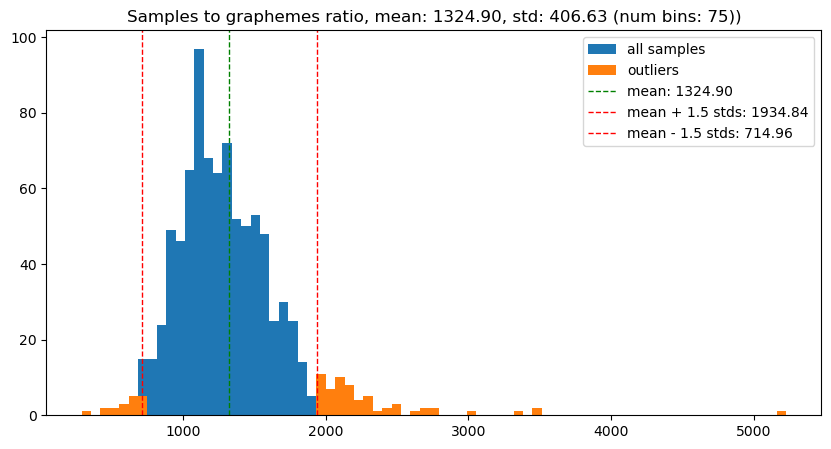

In [286]:
plt.rcParams['figure.figsize'] = [10, 5]

# plot histogram of samples_to_graphemes_ratios comparing outliers and non-outliers
NUM_HISTOGRAM_BINS = 75
samples_to_graphemes_ratios = [wav_dict[key]["samples_to_graphemes_ratio"] for key in wav_dict]
samples_to_graphemes_ratios = np.array(samples_to_graphemes_ratios)
mean = np.mean(samples_to_graphemes_ratios)
std = np.std(samples_to_graphemes_ratios)
print(f"mean: {mean:.2f}, std: {std:.2f}")
plt.hist(samples_to_graphemes_ratios, bins=NUM_HISTOGRAM_BINS, label="all samples")
plt.hist([wav_dict[key]["samples_to_graphemes_ratio"] for key in outliers], bins=NUM_HISTOGRAM_BINS, label=f"outliers ({NUM_STDS} stds)")
plt.legend()
plt.title(f"Samples to graphemes ratio, mean: {mean:.2f}, std: {std:.2f} (num bins: {NUM_HISTOGRAM_BINS}))")
# show cutoffs
plt.axvline(mean, color='g', linestyle='dashed', linewidth=1)
plt.axvline(mean + NUM_STDS * std, color='r', linestyle='dashed', linewidth=1)
plt.axvline(mean - NUM_STDS * std, color='r', linestyle='dashed', linewidth=1)
# show mean line and add legend for it
plt.legend(["all samples", "outliers", f"mean: {mean:.2f}", f"mean + {NUM_STDS} stds: {mean + NUM_STDS * std:.2f}", f"mean - {NUM_STDS} stds: {mean - NUM_STDS * std:.2f}"])
plt.show()

In [274]:
# play audio for outliers and print their wordtype
# sort outliers by samples_to_graphemes_ratio
outliers = sorted(outliers, key=lambda x: wav_dict[x]["samples_to_graphemes_ratio"], reverse=False)
NUM_TO_LISTEN = 10
for i, outlier in enumerate(outliers):
    wav = wav_dict[outlier]["wav"]
    print(outlier, f"ratio: {wav_dict[outlier]['samples_to_graphemes_ratio']:.2f}")
    display(Audio(wav, rate=SAMPLING_RATE))
    if i > NUM_TO_LISTEN:
        break


basle__LJ001-0028__occ1__len1440 ratio: 288.00


though__LJ001-0071__occ1__len2560 ratio: 426.67


though__LJ001-0115__occ1__len2880 ratio: 480.00


whether__LJ001-0117__occ1__len3520 ratio: 502.86


would__LJ001-0100__occ1__len2720 ratio: 544.00


though__LJ001-0089__occ1__len3360 ratio: 560.00


though__LJ001-0050__occ1__len3680 ratio: 613.33


founts__LJ001-0092__occ1__len3680 ratio: 613.33


gunther__LJ001-0037__occ1__len4480 ratio: 640.00


though__LJ001-0088__occ1__len3840 ratio: 640.00


little__LJ001-0070__occ1__len3840 ratio: 640.00


letter__LJ001-0023__occ1__len4000 ratio: 666.67


In [ ]:
raise ValueError("stop before creating datasplits")

# create train,dev,test datasplits for training respeller

We hold out WORDTYPES from training for the dev and test splits

## Random

In [ ]:
import random
import json

random.seed(1337)

train_ratio, dev_ratio, test_ratio = [0.9, 0.05, 0.05]

In [ ]:
# get oov wordtypes list (words that are not seen in tts training)
oov_wordlist_path = '/home/s1785140/data/ljspeech_fastpitch/oov_list.json'
with open(oov_wordlist_path, 'r') as f:
    oovs_and_freqs = json.load(f)
    
all_wordtypes = set(oovs_and_freqs.keys())
print(f'original before cleaning/sampling {len(all_wordtypes)=}')

In [ ]:
# clean/remove words that do not have speech reps
words_with_aligned_mels = set(os.listdir(args.output_directory))
words_no_mels = all_wordtypes - words_with_aligned_mels
print(f'{len(words_no_mels)}=')

In [ ]:
print("list of words to be excluded from respeller training as they do not have mels (likely due to how normalisation is different between mfa and our own data processing):")
words_no_mels

In [ ]:
# sort

In [ ]:
# remove these problematic words from respeller training dev test
for w in words_no_mels:
    del oovs_and_freqs[w]
    
all_wordtypes = set(oovs_and_freqs.keys())
print(f'original after cleaning {len(all_wordtypes)=}')

dev_N = int(dev_ratio * len(all_wordtypes))
test_N = int(test_ratio * len(all_wordtypes))

In [ ]:
def sample_and_remove(s: set, N: int):
    """sample N words from set s
    then remove these words from the set"""
    sampled = random.sample(s, N)
    for item in sampled:
        s.remove(item)
    return set(sampled)

In [ ]:
#get dev and test splits
oov_singletons = set(wordtype for wordtype, freq in oovs_and_freqs.items() if freq == 1)
assert len(oov_singletons) > dev_N + test_N, "not enough OOV singletons to create dev and test sets" 
print(f'before sampling dev and test {len(oov_singletons)=}')

dev = sample_and_remove(oov_singletons, dev_N)
print(f'after sampling dev {len(oov_singletons)=}, {len(dev)=}')

test = sample_and_remove(oov_singletons, test_N)
print(f'after sampling test {len(oov_singletons)=}, {len(test)=}')

In [ ]:
list(dev)[:10]

In [ ]:
list(test)[:10]

In [ ]:
#get train split
print(f'before removing dev and test wordtypes {len(all_wordtypes)=}')
for word in dev | test:
    all_wordtypes.remove(word)
print(f'after removing dev and test wordtypes {len(all_wordtypes)=}')

train = set(all_wordtypes)

In [ ]:
# sanity checks
assert len(dev.intersection(test)) == 0
assert len(train.intersection(dev)) == 0
assert len(train.intersection(test)) == 0
print("Good! No overlapping words between train, dev, and test!!!")

In [ ]:
# write to disk
def save_wordlist(path, words):
    with open(path, 'w') as f:
        json.dump(sorted(list(words)), f, indent=4)
        
train_path = '/home/s1785140/data/ljspeech_fastpitch/respeller_train_words.json'
dev_path = '/home/s1785140/data/ljspeech_fastpitch/respeller_dev_words.json'
test_path = '/home/s1785140/data/ljspeech_fastpitch/respeller_test_words.json'

save_wordlist(train_path, train)
save_wordlist(dev_path, dev)
save_wordlist(test_path, test)

## G2P selection